## Self-defined Subfunction

In [29]:
### number of pick-up and drop-off passengers per hours

def draw_hours(df_taxi, graph_title):
    # get pick-up and drop-off time only
    df_taxi_time = df_taxi.loc[:,['tpep_pickup_datetime','tpep_dropoff_datetime']]
    df_taxi_time['tpep_pickup_datetime'] = pd.to_datetime(df_taxi_time['tpep_pickup_datetime'])
    df_taxi_time['tpep_dropoff_datetime'] = pd.to_datetime(df_taxi_time['tpep_dropoff_datetime'])
    df_taxi_time['tpep_pickup_datetime'] = [time.time() for time in df_taxi_time['tpep_pickup_datetime']]
    df_taxi_time['tpep_dropoff_datetime'] = [time.time() for time in df_taxi_time['tpep_dropoff_datetime']]
    #display(df_taxi_time)
    
    # group by hours
    grp_PU = df_taxi_time['tpep_pickup_datetime']
    grp_PU = grp_PU.groupby(by=[grp_PU.map(lambda x : (x.hour))])
    grp_DO = df_taxi_time['tpep_dropoff_datetime']
    grp_DO = grp_DO.groupby(by=[grp_DO.map(lambda x : (x.hour))])
    display(grp_PU.count())
    display(grp_DO.count())
    
    # define the line
    grp_PU.count().plot(kind='line', label='Pick-up', marker='o', color='blue')
    grp_DO.count().plot(kind='line', label='Drop-off', marker='o', color='green')
    mean = plt.axhline(y=grp_PU.count().mean(), label='Mean', linestyle='--', color='tomato')
    
    # graph config
    plt.title(graph_title) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Time (Hour)")
    plt.ylabel("Number of Passengers")
    plt.xticks(np.arange(0,24,4))
    #display(plt.xticks())
    plt.grid()
    
    plt.show()
    return

def zone_table(df_loc, loc_info):
    
    # group by location id
    df_loc_zone = df_loc.groupby(['LocationID']).size().reset_index(name = "count")
    df_loc_zone['percentage'] = 100 * df_loc_zone['count'] / df_loc_zone['count'].sum()

    # join the info of location id
    df_loc_zone = df_loc_zone.join(loc_info.set_index('LocationID'), on='LocationID', how='left')
    #df_loc_zone = df_loc_zone.merge(loc_info, left_on='LocationID', right_on='LocationID', how='left')

    # sort by count
    df_loc_zone = df_loc_zone.sort_values(by = ['count'], ascending = False).reset_index(drop=True)
    
    return df_loc_zone

def borough_table(df_loc_zone):
    df_loc_bor = df_loc_zone.loc[:,['count', 'borough']]
    df_loc_bor = df_loc_bor.groupby(['borough']).sum().sort_values(by = ['count'], ascending = False).reset_index()
    df_loc_bor['percentage'] = 100 * df_loc_bor['count'] / df_loc_bor['count'].sum()
    return df_loc_bor

def display_percent(df):
    format_dict = {'percentage':'{0:,.4f}%'}
    display(df.head(10).style.format(format_dict).hide_index())
    return

### sub function
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


# Load data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

In [3]:
### Load taxi
#df_taxi = pd.read_csv('green_tripdata_2020-01.csv')
df_taxi = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-02.csv')
#display(df_taxi)

### Load location
df_loc = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv')
#display(df_loc)

/home/silverwing1997/anaconda3/envs/jupyter/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_taxi = df_taxi[((df_taxi.loc[:,['trip_distance']] >= 0) & (df_taxi.loc[:,['trip_distance']] <= 1000)).all(1)]
display(df_taxi)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-02-01 00:17:35,2020-02-01 00:30:32,1.0,2.60,1.0,N,145,7,1.0,11.00,0.50,0.5,2.45,0.0,0.3,14.75,0.0
1,1.0,2020-02-01 00:32:47,2020-02-01 01:05:36,1.0,4.80,1.0,N,45,61,1.0,21.50,3.00,0.5,6.30,0.0,0.3,31.60,2.5
2,1.0,2020-02-01 00:31:44,2020-02-01 00:43:28,1.0,3.20,1.0,N,186,140,1.0,11.00,3.00,0.5,1.00,0.0,0.3,15.80,2.5
3,2.0,2020-02-01 00:07:35,2020-02-01 00:31:39,1.0,4.38,1.0,N,144,140,1.0,18.00,0.50,0.5,3.00,0.0,0.3,24.80,2.5
4,2.0,2020-02-01 00:51:43,2020-02-01 01:01:29,1.0,2.28,1.0,N,238,152,2.0,9.50,0.50,0.5,0.00,0.0,0.3,10.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6299349,NaN,2020-02-28 14:28:00,2020-02-28 14:54:00,NaN,8.60,NaN,NaN,259,247,NaN,30.81,2.75,0.5,0.00,0.0,0.3,34.36,0.0
6299350,NaN,2020-02-28 14:03:00,2020-02-28 14:11:00,NaN,3.01,NaN,NaN,212,31,NaN,22.59,2.75,0.5,0.00,0.0,0.3,26.14,0.0
6299351,NaN,2020-02-28 14:55:00,2020-02-28 15:02:00,NaN,0.71,NaN,NaN,42,42,NaN,13.43,2.75,0.5,0.00,0.0,0.3,16.98,0.0
6299352,NaN,2020-02-28 14:29:00,2020-02-28 14:51:00,NaN,12.40,NaN,NaN,38,53,NaN,30.54,2.75,0.5,0.00,0.0,0.3,34.09,0.0


In [5]:
### load map
sf = shapefile.Reader("shape2/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]
df_map = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
display(df_map.head())


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


## Q1: What are the most pickups and drop offs region?

In [6]:
# pick-up and drop-off zone
df_PU_loc = df_taxi.loc[:,['PULocationID']].rename(columns={'PULocationID':'LocationID'})
df_DO_loc = df_taxi.loc[:,['DOLocationID']].rename(columns={'DOLocationID':'LocationID'})
loc_info = df_map[["LocationID", "zone", "borough"]]
df_PU_zone = zone_table(df_PU_loc, loc_info)
df_DO_zone = zone_table(df_DO_loc, loc_info)

# output
format_dict = {'percentage':'{0:,.4f}%'}
print("\nPick-up :")
display_percent(df_PU_zone.head(10))
print("\nDrop-off :")
display_percent(df_DO_zone.head(10))



Pick-up :


LocationID,count,percentage,zone,borough
161,277369,4.4031%,Midtown Center,Manhattan
237,276289,4.3860%,Upper East Side South,Manhattan
236,258658,4.1061%,Upper East Side North,Manhattan
162,232541,3.6915%,Midtown East,Manhattan
230,226278,3.5921%,Times Sq/Theatre District,Manhattan
186,225565,3.5808%,Penn Station/Madison Sq West,Manhattan
234,193031,3.0643%,Union Sq,Manhattan
170,191817,3.0450%,Murray Hill,Manhattan
48,190547,3.0249%,Clinton East,Manhattan
142,188855,2.9980%,Lincoln Square East,Manhattan



Drop-off :


LocationID,count,percentage,zone,borough
236,272802,4.3306%,Upper East Side North,Manhattan
237,250885,3.9827%,Upper East Side South,Manhattan
161,244454,3.8806%,Midtown Center,Manhattan
170,194726,3.0912%,Murray Hill,Manhattan
230,188214,2.9878%,Times Sq/Theatre District,Manhattan
162,188016,2.9847%,Midtown East,Manhattan
142,171781,2.7270%,Lincoln Square East,Manhattan
234,168084,2.6683%,Union Sq,Manhattan
48,168048,2.6677%,Clinton East,Manhattan
239,164119,2.6053%,Upper West Side South,Manhattan


- We can see that both of the most pick-up and drop-off zone is **East Harlem North**.
- However, the percentage of the top-10 zones are similar, we consider the most pick-up and drop-off borough next to see if there is any significant result.

In [7]:
# pick-up and drop-off borough
df_PU_bor = borough_table(df_PU_zone)
df_DO_bor = borough_table(df_DO_zone)
print("\nPick-up :")
display_percent(df_PU_bor)
print("\nDrop-off :")
display_percent(df_DO_bor)


Pick-up :


borough,count,percentage
Manhattan,5797814,92.6372%
Queens,380675,6.0824%
Brooklyn,67971,1.0860%
Bronx,11283,0.1803%
EWR,621,0.0099%
Staten Island,262,0.0042%



Drop-off :


borough,count,percentage
Manhattan,5635947,90.0534%
Queens,317321,5.0703%
Brooklyn,251153,4.0130%
Bronx,41115,0.6570%
EWR,11461,0.1831%
Staten Island,1452,0.0232%


- We can see that both of the most pick-up and drop-off borough is **Manhattan**.

## Q2: When are the peak hours and off-peak hours for taking taxi?
- We consider both pick-up and drop-off data.

tpep_pickup_datetime
0     172625
1     119860
2      87011
3      60420
4      45949
5      52823
6     120074
7     230285
8     296370
9     295255
10    289345
11    303608
12    328220
13    334051
14    353606
15    362292
16    346819
17    397643
18    438395
19    396794
20    350411
21    347485
22    322169
23    247839
Name: tpep_pickup_datetime, dtype: int64

tpep_dropoff_datetime
0     190086
1     130200
2      93406
3      63441
4      48507
5      46865
6     104867
7     202559
8     281071
9     300016
10    291413
11    297905
12    325803
13    330441
14    343241
15    361495
16    345751
17    383579
18    440175
19    416998
20    355380
21    348737
22    331576
23    265837
Name: tpep_dropoff_datetime, dtype: int64

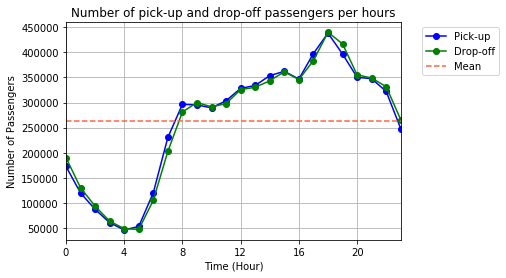

In [30]:
# draw graph
draw_hours(df_taxi, "Number of pick-up and drop-off passengers per hours")

<style>
    RR {
        color: "red";
    }
</style>

- By the graph above, both <font color="red">9 a.m. \~ 10 a.m. and 4 p.m. \~ 7 p.m.</font> are the <font color="red">peak</font> hours.
- The <font color="blue">off-peak</font> hours are <font color="blue">2 a.m. \~ 5 a.m.</font>


## Q3: What are the differences between short and long distance trips of taking taxi?
### Step:
    1. Define short and long distance trips
    2. Observe Spatial Difference
    3. Observe Temporal Difference

### 3-1 Define short and long distance trips
- Let's draw the graphs first and observe them.

,trip_distance
count,6.299349e+06
mean,2.830492e+00
std,3.690133e+00
min,0.000000e+00
25%,9.600000e-01
50%,1.600000e+00
75%,2.900000e+00
max,3.699400e+02


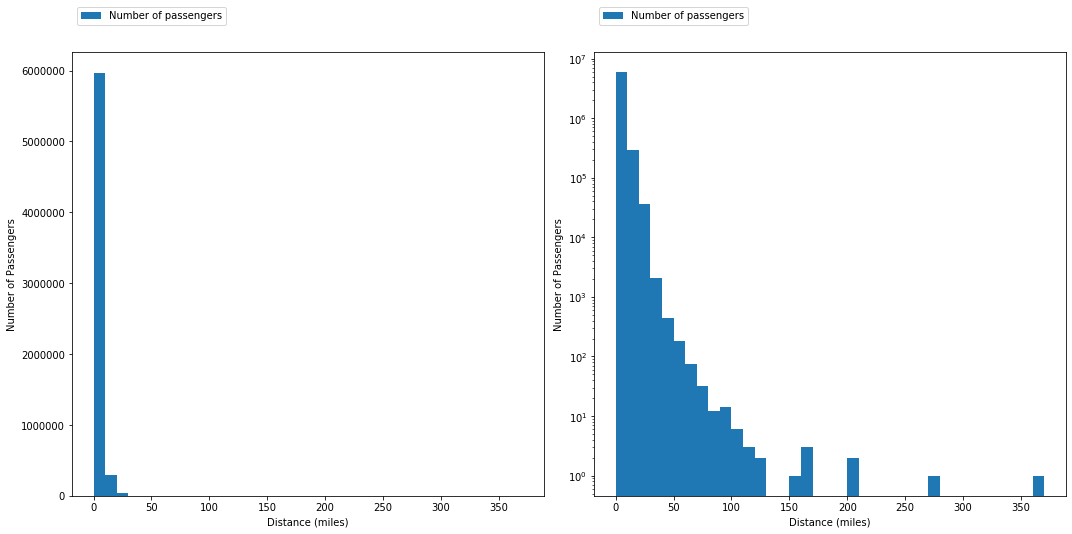

In [17]:
'''
3-1
'''
### type transform
df_taxi_dis = df_taxi.loc[:,['trip_distance']]
df_taxi_dis['trip_distance'] = pd.to_numeric(df_taxi_dis['trip_distance'], errors='coerce')
#print(df_taxi_dis.dtypes)
#print(df_taxi_dis.describe().loc[['max']])

### set the class interval of the graph
class_interval = 10
max_dis = df_taxi_dis.describe().loc[['max']].iloc[0]
bins_list = range(0, math.ceil(float(max_dis + class_interval)), class_interval)
#print(max_dis)
#print(*bins_list)

### show the graph
display(df_taxi_dis.describe())

#fig, ax = plt.subplots(1, 2)
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
df_taxi_dis['trip_distance'].plot(ax=ax[0], kind='hist', bins=bins_list, label='Number of passengers')
ax[0].set_yscale('linear')
ax[0].set_xlabel("Distance (miles)")
ax[0].set_ylabel("Number of Passengers")
ax[0].legend(bbox_to_anchor=(0, 1.05), loc='lower left')
ax[0].axis('auto')
#ax[0].set_xlim(0, 1000)

df_taxi_dis['trip_distance'].plot(ax=ax[1], kind='hist', bins=bins_list, label='Number of passengers')
ax[1].set_yscale('log')
ax[1].set_xlabel("Distance (miles)")
ax[1].set_ylabel("Number of Passengers")
ax[1].legend(bbox_to_anchor=(0, 1.05), loc='lower left')
ax[1].axis('auto')
#ax[1].set_xlim(0, 1000)

fig.tight_layout()
plt.show()


- By observing the graph above, we split short and long distance trips by <font color="red">**30(mils)**</font>.
- Then, we split the dataset next.

In [28]:
split_gap = 30
df_taxi_short = df_taxi[(df_taxi.loc[:,['trip_distance']] < split_gap).all(1)]
df_taxi_long = df_taxi[(df_taxi.loc[:,['trip_distance']] >= split_gap).all(1)]

print("Number / percentage of short-distance trips :", df_taxi_short.shape[0], "/", round(100 * df_taxi_short.shape[0] / df_taxi.shape[0], 2), "%")
print("Number / percentage of long-distance trips :", df_taxi_long.shape[0], "/", round(100 * df_taxi_long.shape[0] / df_taxi.shape[0], 2), "%")


Number / percentage of short-distance trips : 6296496 / 99.95 %
Number / percentage of long-distance trips : 2853 / 0.05 %


### 3-2 Observe spatial difference

- zone and borough of the short-distance trips

In [11]:
# pick-up and drop-off zone for short distance trips
df_PU_loc_S = df_taxi_short.loc[:,['PULocationID']].rename(columns={'PULocationID':'LocationID'})
df_DO_loc_S = df_taxi_short.loc[:,['DOLocationID']].rename(columns={'DOLocationID':'LocationID'})
loc_info = df_map[["LocationID", "zone", "borough"]]
df_PU_zone_S = zone_table(df_PU_loc_S, loc_info)
df_DO_zone_S = zone_table(df_DO_loc_S, loc_info)

# output
format_dict = {'percentage':'{0:,.4f}%'}
print("\nPick-up :")
display_percent(df_PU_zone_S.head(10))
print("\nDrop-off :")
display_percent(df_DO_zone_S.head(10))


Pick-up :


LocationID,count,percentage,zone,borough
161,277339,4.4047%,Midtown Center,Manhattan
237,276265,4.3876%,Upper East Side South,Manhattan
236,258654,4.1079%,Upper East Side North,Manhattan
162,232526,3.6929%,Midtown East,Manhattan
230,226237,3.5931%,Times Sq/Theatre District,Manhattan
186,225508,3.5815%,Penn Station/Madison Sq West,Manhattan
234,193020,3.0655%,Union Sq,Manhattan
170,191798,3.0461%,Murray Hill,Manhattan
48,190512,3.0257%,Clinton East,Manhattan
142,188853,2.9993%,Lincoln Square East,Manhattan



Drop-off :


LocationID,count,percentage,zone,borough
236,272801,4.3326%,Upper East Side North,Manhattan
237,250862,3.9842%,Upper East Side South,Manhattan
161,244451,3.8823%,Midtown Center,Manhattan
170,194723,3.0926%,Murray Hill,Manhattan
230,188204,2.9890%,Times Sq/Theatre District,Manhattan
162,188013,2.9860%,Midtown East,Manhattan
142,171780,2.7282%,Lincoln Square East,Manhattan
234,168083,2.6695%,Union Sq,Manhattan
48,168040,2.6688%,Clinton East,Manhattan
239,164117,2.6065%,Upper West Side South,Manhattan


In [12]:
# pick-up and drop-off borough for short distance trips
df_PU_bor_S = borough_table(df_PU_zone_S)
df_DO_bor_S = borough_table(df_DO_zone_S)
print("\nPick-up :")
display_percent(df_PU_bor_S)
print("\nDrop-off :")
display_percent(df_DO_bor_S)


Pick-up :


borough,count,percentage
Manhattan,5797065,92.6664%
Queens,378820,6.0555%
Brooklyn,67911,1.0856%
Bronx,11235,0.1796%
EWR,619,0.0099%
Staten Island,195,0.0031%



Drop-off :


borough,count,percentage
Manhattan,5635712,90.0664%
Queens,316985,5.0659%
Brooklyn,251033,4.0119%
Bronx,41029,0.6557%
EWR,11181,0.1787%
Staten Island,1343,0.0215%


- zone and borough of the long-distance trips

In [13]:
# pick-up and drop-off zone for long distance trips
df_PU_loc_L = df_taxi_long.loc[:,['PULocationID']].rename(columns={'PULocationID':'LocationID'})
df_DO_loc_L = df_taxi_long.loc[:,['DOLocationID']].rename(columns={'DOLocationID':'LocationID'})
loc_info = df_map[["LocationID", "zone", "borough"]]
df_PU_zone_L = zone_table(df_PU_loc_L, loc_info)
df_DO_zone_L = zone_table(df_DO_loc_L, loc_info)

# output
format_dict = {'percentage':'{0:,.4f}%'}
print("\nPick-up :")
display_percent(df_PU_zone_L.head(10))
print("\nDrop-off :")
display_percent(df_DO_zone_L.head(10))


Pick-up :


LocationID,count,percentage,zone,borough
132,1349,47.2836%,JFK Airport,Queens
138,292,10.2348%,LaGuardia Airport,Queens
186,57,1.9979%,Penn Station/Madison Sq West,Manhattan
158,53,1.8577%,Meatpacking/West Village West,Manhattan
265,48,1.6824%,nan,nan
68,45,1.5773%,East Chelsea,Manhattan
230,41,1.4371%,Times Sq/Theatre District,Manhattan
48,35,1.2268%,Clinton East,Manhattan
246,32,1.1216%,West Chelsea/Hudson Yards,Manhattan
100,32,1.1216%,Garment District,Manhattan



Drop-off :


LocationID,count,percentage,zone,borough
265,1669,58.4998%,nan,nan
1,280,9.8142%,Newark Airport,EWR
132,163,5.7133%,JFK Airport,Queens
44,36,1.2618%,Charleston/Tottenville,Staten Island
237,23,0.8062%,Upper East Side South,Manhattan
135,22,0.7711%,Kew Gardens Hills,Queens
117,19,0.6660%,Hammels/Arverne,Queens
158,19,0.6660%,Meatpacking/West Village West,Manhattan
264,18,0.6309%,nan,nan
200,17,0.5959%,Riverdale/North Riverdale/Fieldston,Bronx


In [14]:
# pick-up and drop-off borough for long distance trips
df_PU_bor_L = borough_table(df_PU_zone_L)
df_DO_bor_L = borough_table(df_DO_zone_L)
print("\nPick-up :")
display_percent(df_PU_bor_L)
print("\nDrop-off :")
display_percent(df_DO_bor_L)


Pick-up :


borough,count,percentage
Queens,1855,66.7026%
Manhattan,749,26.9328%
Staten Island,67,2.4092%
Brooklyn,60,2.1575%
Bronx,48,1.7260%
EWR,2,0.0719%



Drop-off :


borough,count,percentage
Queens,336,28.8165%
EWR,280,24.0137%
Manhattan,235,20.1544%
Brooklyn,120,10.2916%
Staten Island,109,9.3482%
Bronx,86,7.3756%


### 3-3 Observe temporal difference


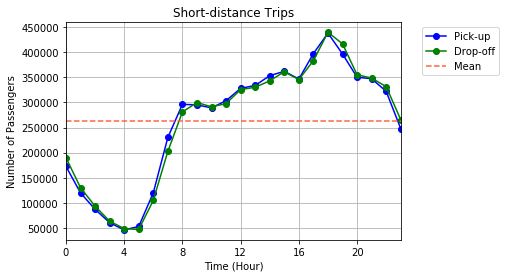

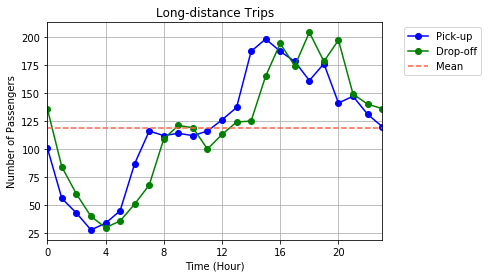

In [15]:
draw_hours(df_taxi_short, "Short-distance Trips")
draw_hours(df_taxi_long, "Long-distance Trips")

- By the graphs above, we can see that tendency of pick-up and drop-off time are similar in both two graph.
- For **long distance trips**, the tendency of drop-off time is **1-hour later** than the pick-up time.
- Both peak and off-peak hours of the long-distance trips are about 1 \~ 2 hours earlier than the short-distance trips.

- The peak hours and the off-peak hours for short and long trips:

|                    | Peak Hours | Off-peak Hours |
| ------------------ | -------------- | ------------- |
| **Short-distance** | 9 a.m. \~ 10 a.m.<br>4 p.m. \~ 7 p.m. | 1 a.m. \~ 5 a.m. |
| **Long-distance**  | 11 a.m. \~ 12 a.m.<br>3 p.m. \~ 5 p.m. | 0 a.m. \~ 4 a.m. |

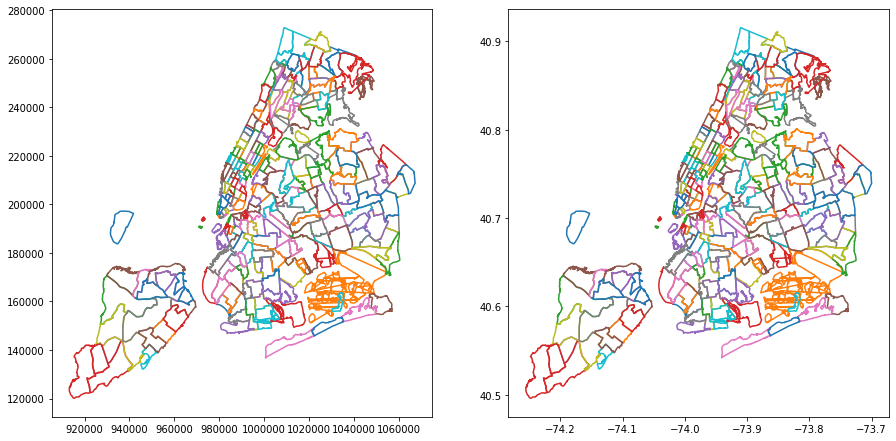

In [20]:
def draw_map(shpFilePath, ax):
    sf = shapefile.Reader(shpFilePath)
    # plt.figure(figsize=(7.5, 7.5))
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y)
    #ax.axis('equal')
    #ax.axis('square')
    #plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
ax = plt.subplot(1, 2, 1)
draw_map("shape/taxi_zones.shp", ax)
ax = plt.subplot(1, 2, 2)
draw_map("shape2/taxi_zones.shp", ax)